In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import seaborn as sns
import shap

In [12]:
# Crea i dati per predire il prezzo tra 3 ggs

stock = "AAPL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

df["Train"] = df["Close"].shift(-3)
df.dropna(subset=['Train'], inplace=True)


Found 27 features with positive correlation to 'Train'.
Close           0.999241
Close_lag1      0.999000
Close_lag3      0.998557
SMA             0.998049
Close_lag7      0.997744
Boll_Up         0.997596
Boll_Down       0.997443
EMA50           0.997079
EMA50_lag1      0.996889
EMA200          0.993111
EMA200_lag1     0.992976
ATR             0.926317
MACD_Signal     0.247171
MACD            0.238476
Dist_up_band    0.105189
+DI             0.053181
MACD_Hist       0.025858
-DI             0.020682
%D              0.020170
%D_lag1         0.019666
W%R             0.019318
%K              0.019318
%K_lag1         0.018875
BB_pctB         0.013549
Month           0.009650
RSI             0.004099
RSI_lag1        0.003819


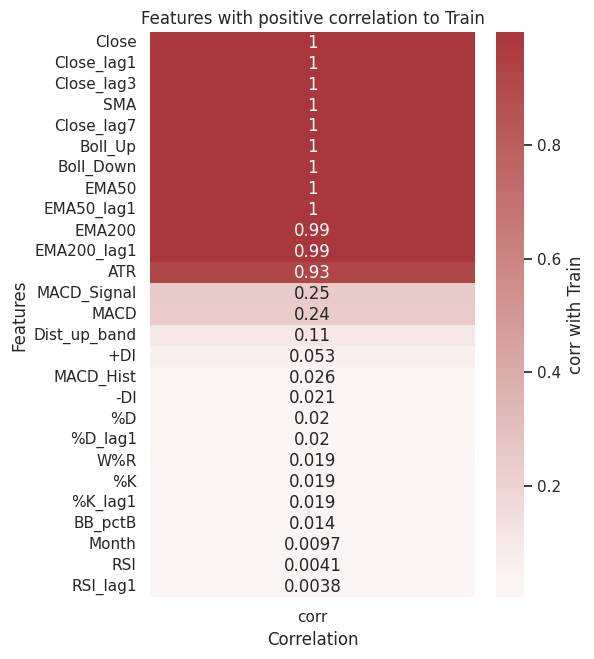

In [13]:
# List features with correlation > 0 w.r.t 'Train' and plot their correlations
if 'Train' not in df.columns:
    print("Column 'Train' not found in df. Run the data prep cell first.")
else:
    # Espressa anche close, per retrocmpatibiltà con il codice sotto stante
    corr = df.corr()
    # extract correlation with Train (drop the Train->Train self-correlation)
    corr_train = corr['Train'].drop(labels=['Train'], errors='ignore')
    pos_features = corr_train[corr_train > 0].sort_values(ascending=False)

    print(f"Found {len(pos_features)} features with positive correlation to 'Train'.")
    if len(pos_features) > 0:
        print(pos_features.to_string())

        # convert to one-column DataFrame and plot a vertical heatmap
        pos_df = pos_features.to_frame(name='corr')
        plt.figure(figsize=(6, max(4, 0.25 * len(pos_df))))
        sns.set_theme(style='white')
        ax = sns.heatmap(pos_df, annot=True, cmap='vlag', center=0, cbar_kws={'label': 'corr with Train'})
        ax.set_xlabel('Correlation')
        ax.set_ylabel('Features')
        plt.title("Features with positive correlation to Train")
        plt.tight_layout()
        plt.show()
    else:
        print("No features have positive correlation with 'Train'.")

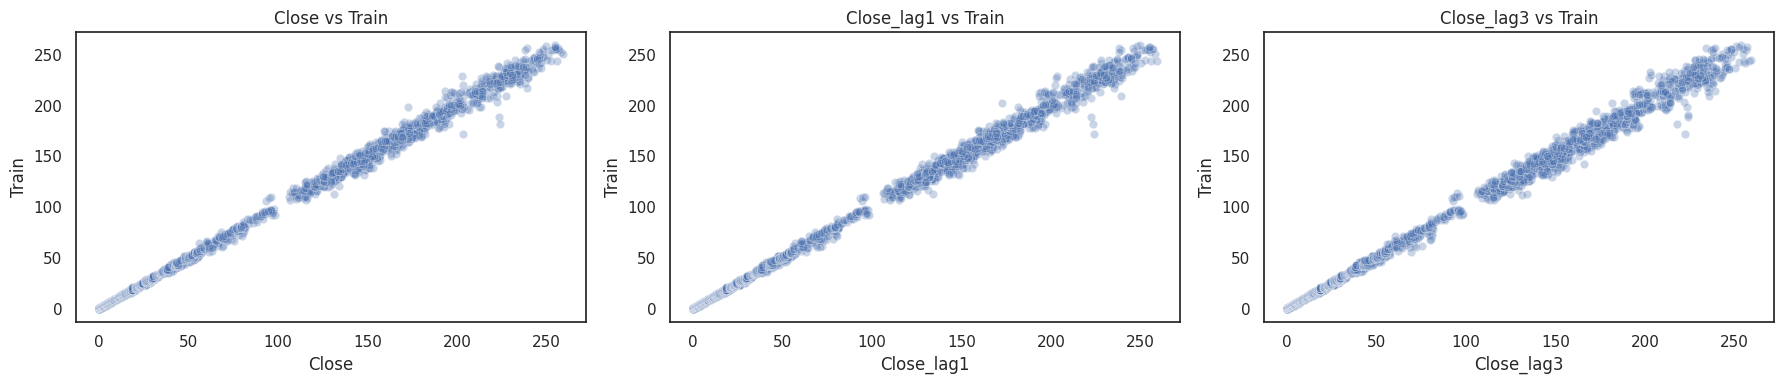

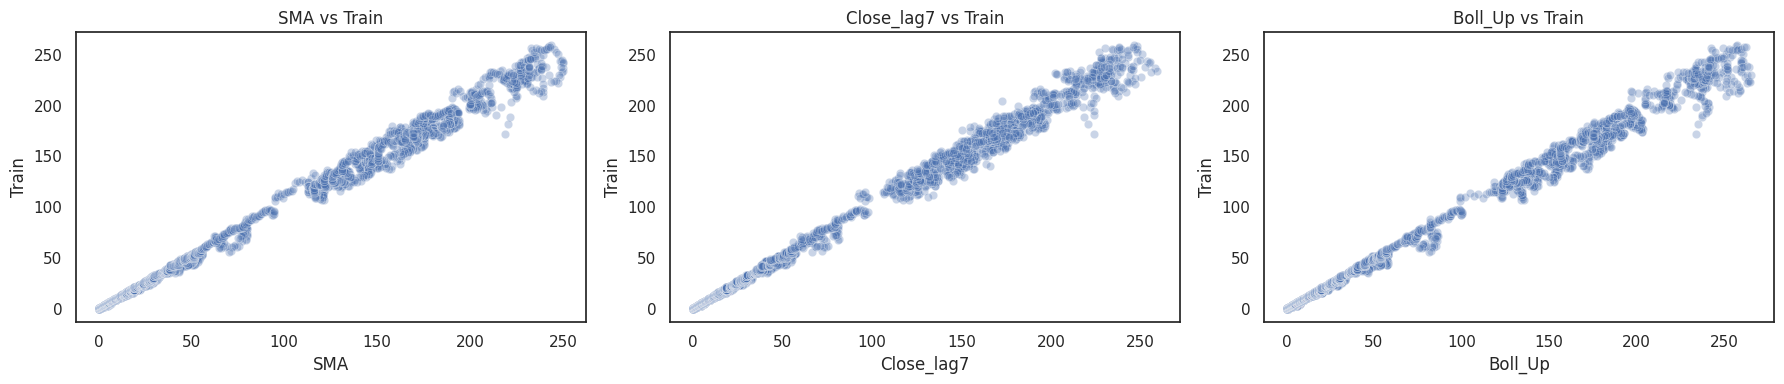

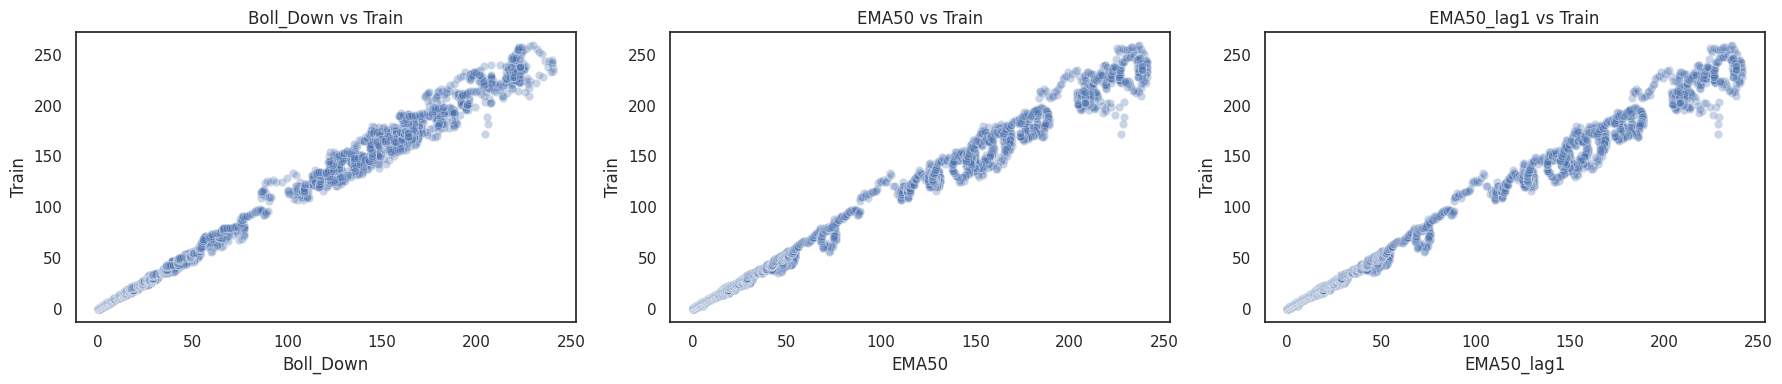

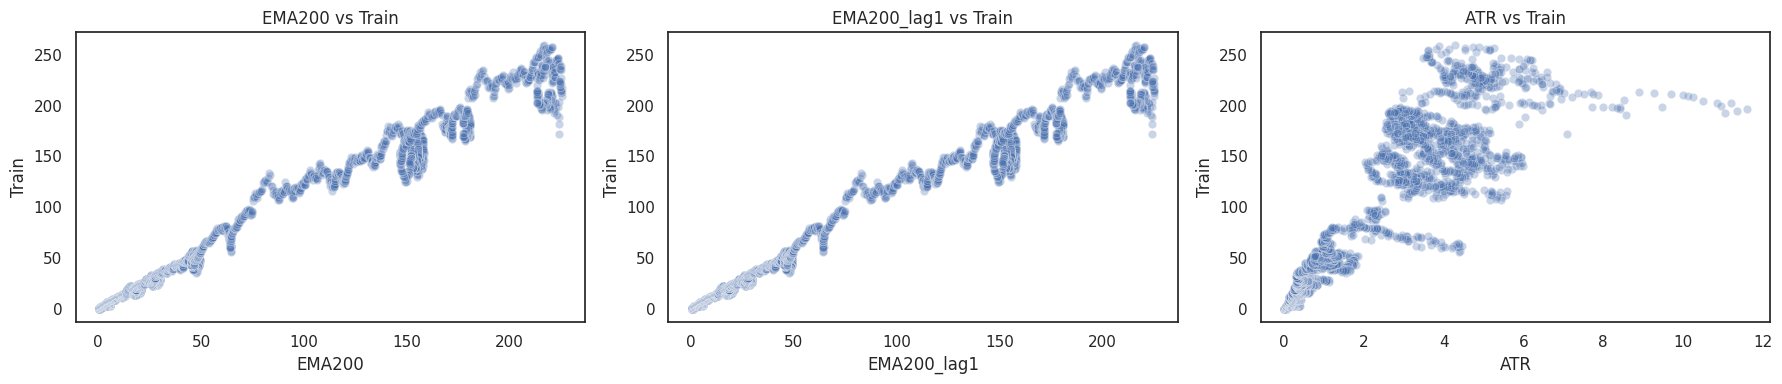

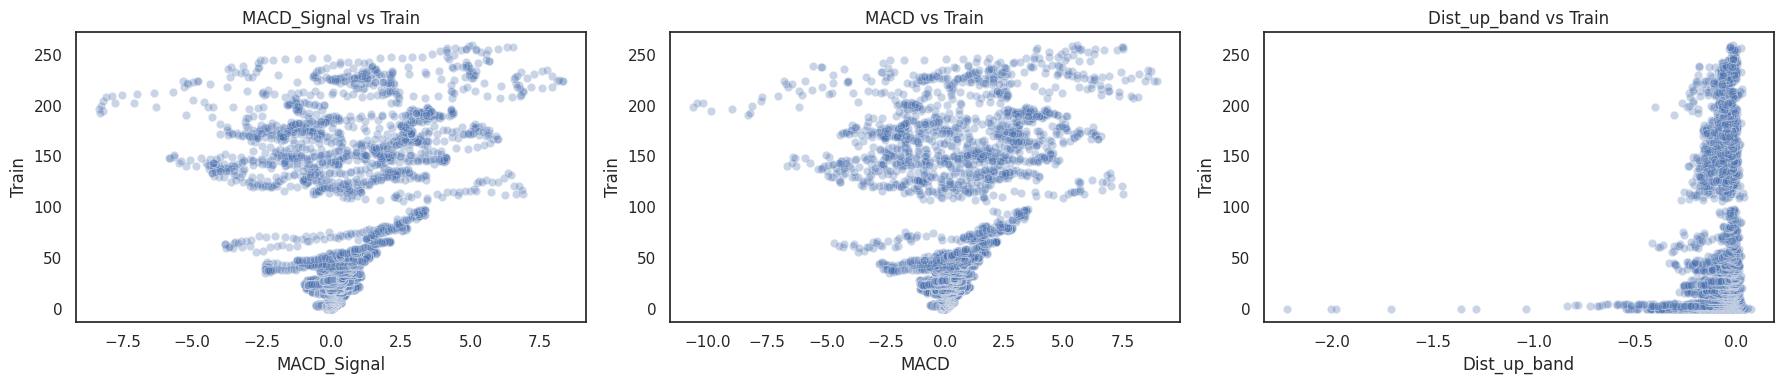

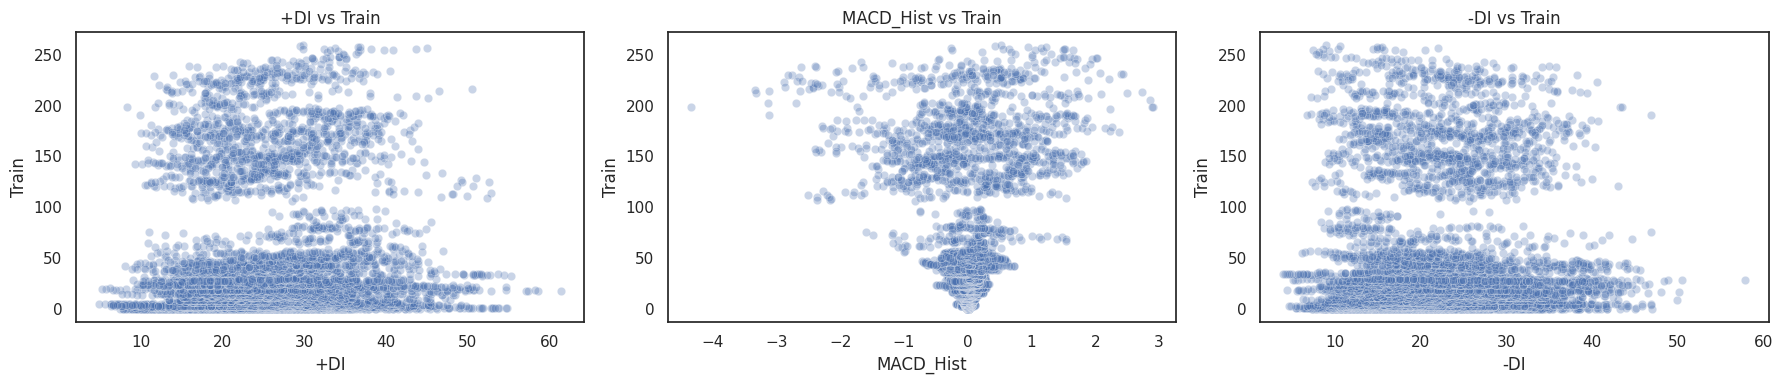

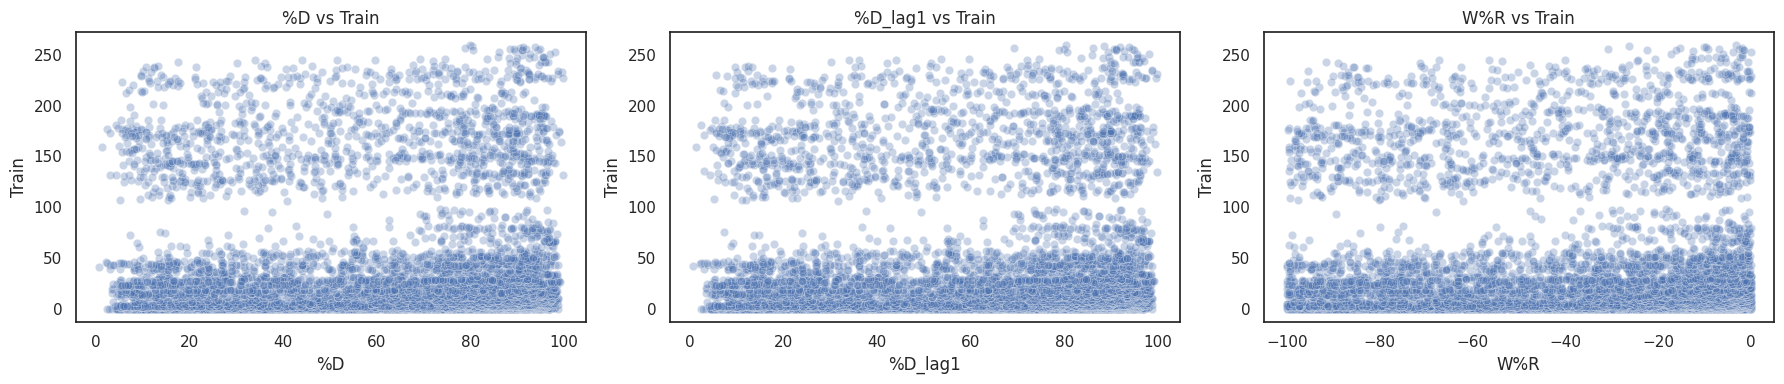

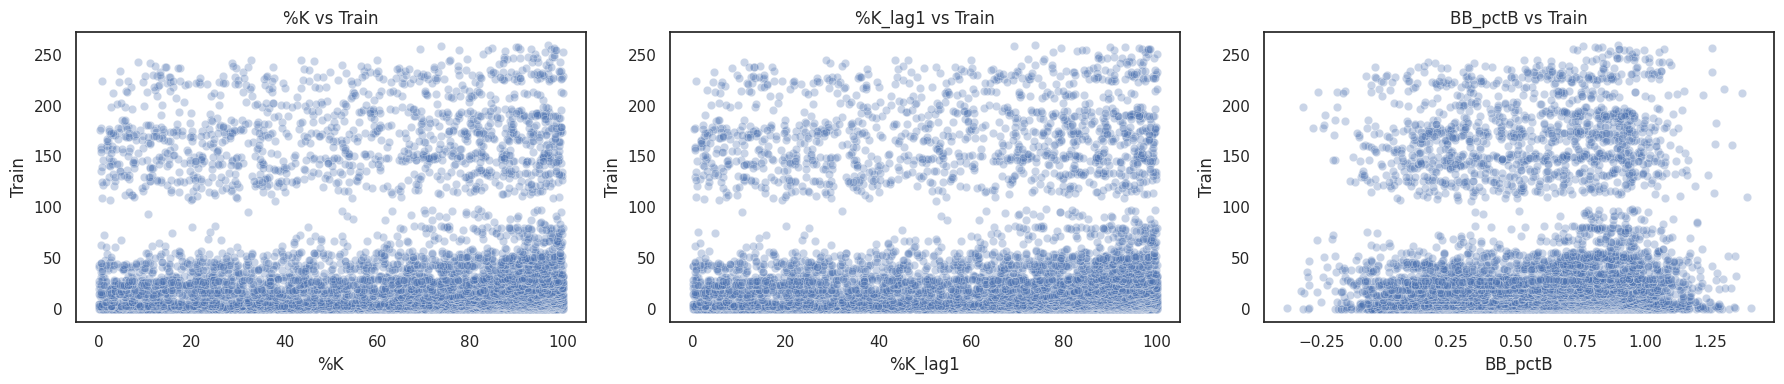

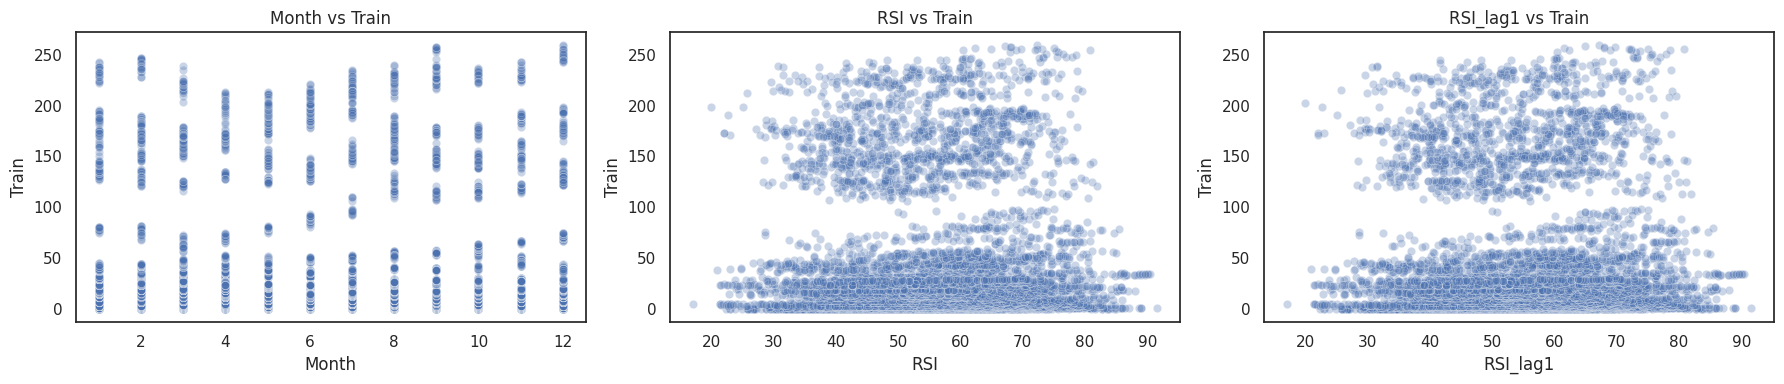

In [14]:
#Scatter plot
cols = list(df[pos_features.index].columns)
n = len(cols)
for i in range(0, n, 3):
    fig, axes = plt.subplots(1, min(3, n - i), figsize=(18, 4))
    if min(3, n - i) == 1:
        axes = [axes]
    for j, col in enumerate(cols[i:i+3]):
        sns.scatterplot(ax=axes[j], data=df, x=col, y='Train', alpha=0.3)
        axes[j].set_title(f"{col} vs Train")
    plt.tight_layout()
    plt.show()

In [15]:
#Data set 
X = df[ pos_features.index]
Y = df["Train"]
tscv = TimeSeriesSplit(n_splits=2)

data_set = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    data_set.append({
        "X_train": X_train.drop(columns=["Close"]).copy(),
        "X_test": X_test.drop(columns=["Close"]).copy(),
        "Y_train": Y_train.copy(),
        "Y_test": Y_test.copy(),
        "Reality": X_test["Close"].copy()
    })

Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 0.6379 | MAE: 0.4653 | R2: 0.9946 | base R2: 0.9959
Top coefficients:
Close_lag1    1.721937e+00
Boll_Down     1.366053e-01
Close_lag7    4.538054e-02
MACD_Hist     2.441253e-02
W%R           1.033815e-02
MACD          7.136491e-03
BB_pctB       4.959308e-03
RSI           3.018143e-03
%K            4.209618e-16
Close_lag3    0.000000e+00


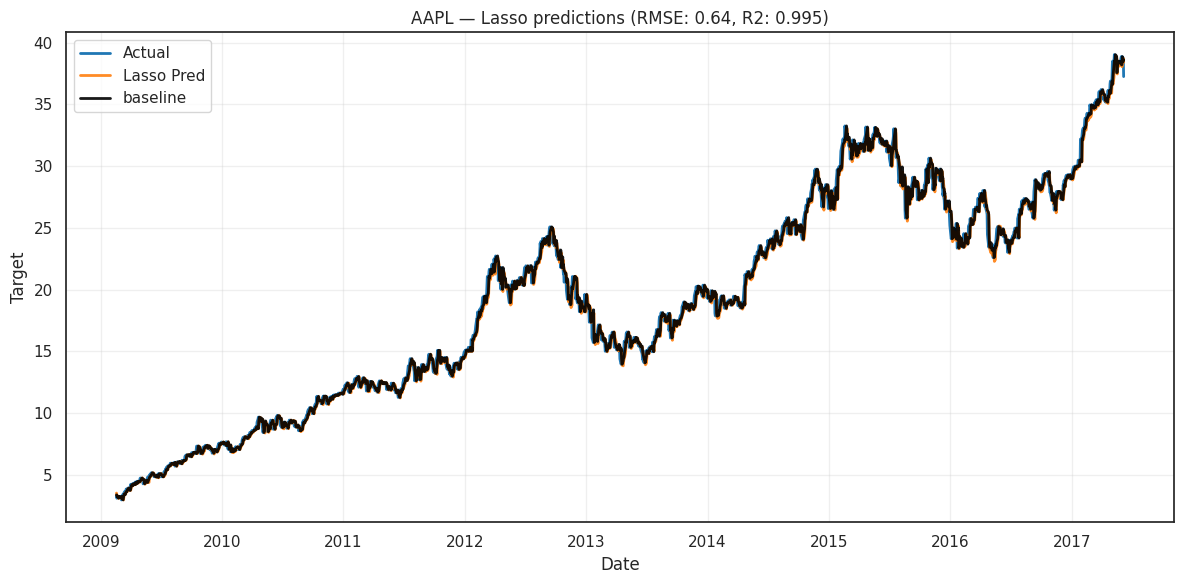

Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 5.1197 | MAE: 3.3899 | R2: 0.9938 | base R2: 0.9952
Top coefficients:
Close_lag1    10.493935
RSI            0.138857
RSI_lag1       0.115907
W%R            0.107530
%K_lag1        0.100824
Close_lag3     0.097558
SMA            0.034400
BB_pctB        0.024770
Close_lag7     0.016203
%D_lag1        0.009899


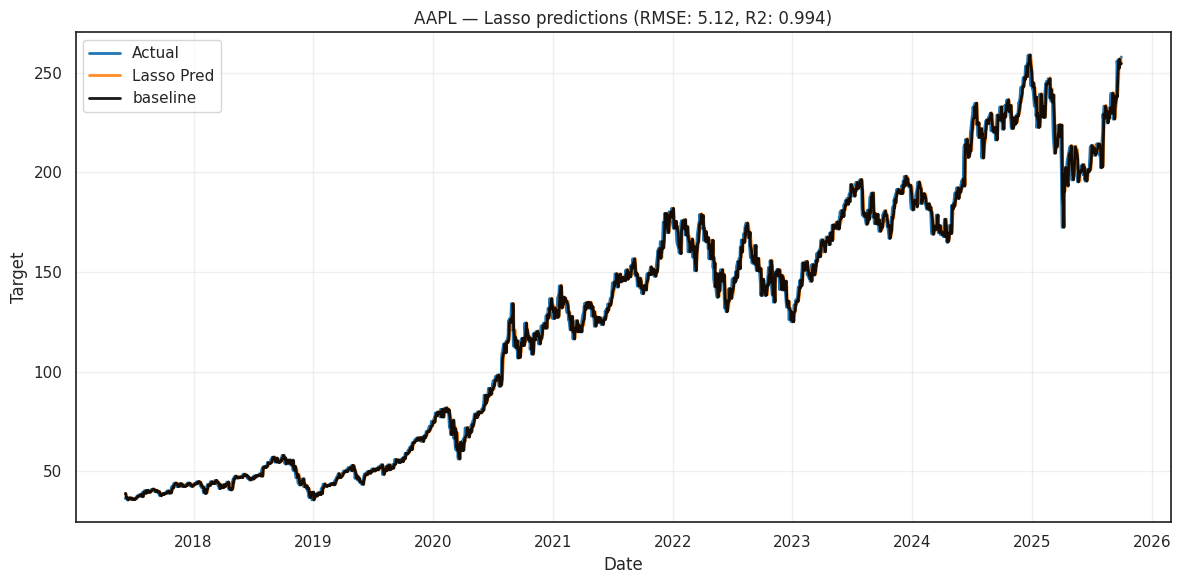

In [16]:
#Lasso regression
for data in data_set:
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.01, 0.1, 0.5, 0.5, 1.0],
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)
    print("Top coefficients:")
    print(coefs.abs().sort_values(ascending=False).head(10).to_string())

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    plt.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — Lasso predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Random forest regresor (deprecated for poor results...)
for data in data_set:
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        "n_estimators": [100, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "max_features": ["log2", "sqrt"]
    }

    gs = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # feature importances
    try:
        fi = pd.Series(best.feature_importances_, index=data["X_train"].columns)
        print("Top features:\n", fi.sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='RF Pred', color='#9467bd', linewidth=2, alpha=0.9)
    plt.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.6)
    plt.title(f"{stock} — RandomForest predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}
RMSE: 0.6018 | MAE: 0.4422 | R2: 0.9952 | base R2: 0.9959
Top coefficients:
Boll_Down     0.304707
Close_lag1    0.301589
SMA           0.277792
Boll_Up       0.264849
EMA50         0.203263
Close_lag7    0.197989
EMA50_lag1    0.192123
Close_lag3    0.165314
MACD_Hist     0.102598
MACD          0.087864


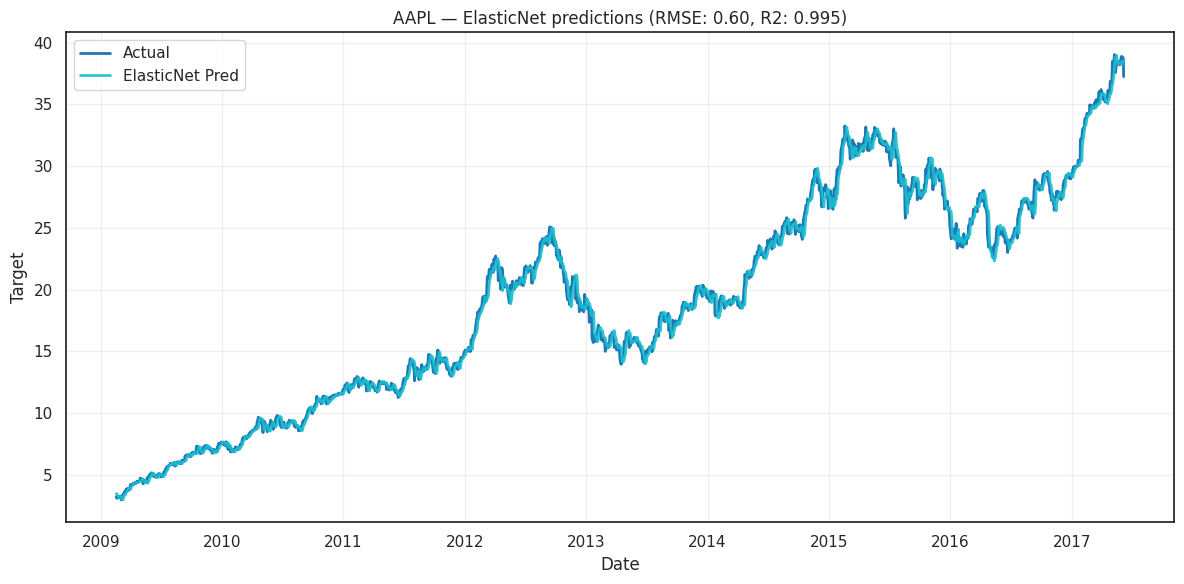

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 4.9072 | MAE: 3.2895 | R2: 0.9943 | base R2: 0.9952
Top coefficients:
Close_lag1    1.974723
Boll_Down     1.858075
Boll_Up       1.761106
SMA           1.572638
EMA50         1.091119
EMA50_lag1    0.947001
Close_lag7    0.711517
Close_lag3    0.659386
MACD          0.304838
MACD_Hist     0.206294


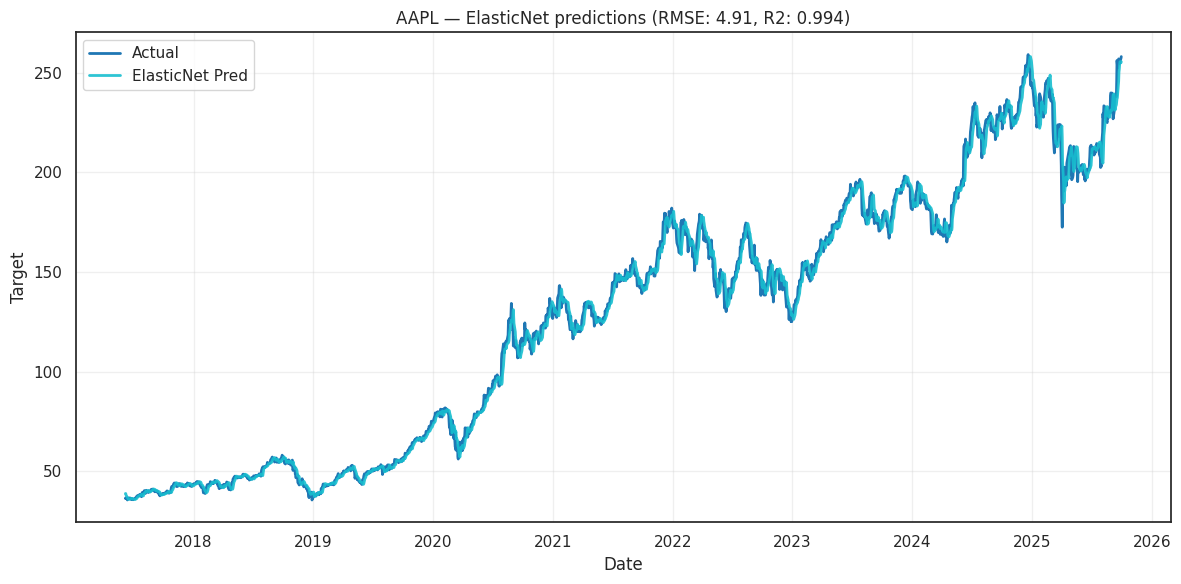

In [17]:
# Elatic-net
for data in data_set:
    pipe = make_pipeline(StandardScaler(), ElasticNet(random_state=42, max_iter=20000))

    param_grid = {
        'elasticnet__alpha': [0.01, 0.1, 0.5, 1.0],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    try:
        enet = best.named_steps['elasticnet']
        coefs = pd.Series(enet.coef_, index=data["X_train"].columns)
        print("Top coefficients:")
        print(coefs.abs().sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='ElasticNet Pred', color='#17becf', linewidth=2, alpha=0.9)
    #plt.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — ElasticNet predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
#Todo: SHAP???